In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import math
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('spotify_songs.csv')
data.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms'],
      dtype='object')

In [3]:
# Veri setindeki sütun adlarını yeniden adlandırma işlemi yapıldı.
data.rename(columns={'track_popularity': 'popularity', 
                     'track_artist': 'artist', 
                     'track_name': 'name', 
                     'track_album_id': 'album_id', 
                     'track_album_name': 'album_name', 
                     'track_album_release_date': 'album_release_date', 
                     'playlist_genre': 'genre', 
                     'playlist_subgenre': 'subgenre'}, inplace=True)

In [4]:

def encode_playlist_info(df):
    """
    Spotify veri setinde playlist bilgilerini anlamlı sayısal temsillere dönüştürür.
    - playlist_genre ve playlist_subgenre sütunlarını one-hot encode eder.
    - Her şarkının yer aldığı playlist sayısını (playlist_count) hesaplar.
    - Gereksiz playlist sütunlarını kaldırır.

    Parametre:
        df (pd.DataFrame): Orijinal Spotify veri seti.

    Dönüş:
        merged_df (pd.DataFrame): Yeni özellikler eklenmiş, playlist sütunları işlenmiş DataFrame.
    """

    df = df.copy()

    # --- 1️⃣ Playlist count: bir şarkı kaç farklı playlist'te var ---
    playlist_count = df.groupby('track_id')['playlist_id'].nunique()
    df['playlist_count'] = df['track_id'].map(playlist_count)

    # --- 2️⃣ Genre encoding: one-hot (multi-label) ---
    genre_dummies = pd.get_dummies(df['genre'], prefix='genre', dtype=int)
    subgenre_dummies = pd.get_dummies(df['subgenre'], prefix='subgenre', dtype=int)

    # Şarkı bazında grupla (aynı şarkı birden fazla genre’de olabilir)
    genre_features = (
        pd.concat([df[['track_id']], genre_dummies, subgenre_dummies], axis=1)
        .groupby('track_id', as_index=False)
        .max()
    )

    # --- 3️⃣ Şarkı bazında unique satır oluştur ---
    base_cols = [
        'track_id', 'name', 'artist', 'album_id', 'album_name',
        'popularity', 'album_release_date',
        'danceability', 'energy', 'key', 'loudness', 'mode',
        'speechiness', 'acousticness', 'instrumentalness',
        'liveness', 'valence', 'tempo', 'duration_ms'
    ]
    base_df = df.drop_duplicates(subset=['track_id'])[base_cols + ['playlist_count']]

    # --- 4️⃣ Merge işlemi ---
    merged_df = base_df.merge(genre_features, on='track_id', how='left')

    # --- 5️⃣ Gereksiz sütunları kaldır ---
    drop_cols = ['playlist_name', 'playlist_id', 'genre', 'subgenre']
    merged_df = merged_df.drop(columns=[c for c in drop_cols if c in merged_df.columns], errors='ignore')

    print(f"✅ encode_playlist_info tamamlandı → Yeni shape: {merged_df.shape}")
    print(f"ℹ️ Genre sütunu sayısı: {len([c for c in merged_df.columns if c.startswith('genre_')])}")
    print(f"ℹ️ Subgenre sütunu sayısı: {len([c for c in merged_df.columns if c.startswith('subgenre_')])}")

    return merged_df

# Spotify veri setini işleme
encoded_data = encode_playlist_info(data)

# Yeni sütunları görmek için:
encoded_data.filter(regex='^(genre_|subgenre_)').head()
encoded_data[encoded_data['track_id'] == '6v3KW9xbzN5yKLt9YKDYA2'].transpose()

data = encoded_data
data[data['track_id'] == '6v3KW9xbzN5yKLt9YKDYA2'].transpose()



✅ encode_playlist_info tamamlandı → Yeni shape: (28356, 50)
ℹ️ Genre sütunu sayısı: 6
ℹ️ Subgenre sütunu sayısı: 24


,1167
track_id,6v3KW9xbzN5yKLt9YKDYA2
name,Señorita
artist,Shawn Mendes
album_id,0xzScN8P3hQAz3BT3YYX5w
album_name,Shawn Mendes (Deluxe)
popularity,88
album_release_date,2019-06-19
danceability,0.759
energy,0.548
key,9


In [5]:
data[data['track_id'].duplicated()]

,track_id,name,artist,album_id,album_name,popularity,album_release_date,danceability,energy,key,...,subgenre_new jack swing,subgenre_permanent wave,subgenre_pop edm,subgenre_post-teen pop,subgenre_progressive electro house,subgenre_reggaeton,subgenre_southern hip hop,subgenre_trap,subgenre_tropical,subgenre_urban contemporary


In [6]:
# Yapılan görselleştirmelerde üretkenlik-popülarite ilişkisi görülmüştür. Sanatçının aktifliğinin popülariteyi etkileyebileceği düşünülmüştür.
# Sanatçıların çıkardıkları toplam şarkı sayısının modele faydası olabileceği öngörülmüştür.
# Sanatçının toplam şarkı sayısı özelliği eklenmiştir.

# Her sanatçının toplam şarkı sayısını hesapla
artist_song_counts = data['artist'].value_counts().to_dict()

# Yeni bir sütun ekleme: her satıra o sanatçının toplam şarkı sayısını ata
data['artist_song_count'] = data['artist'].map(artist_song_counts)

In [7]:
# Artist Ortalama Popülaritesi-Şarkı Popülaritesi ilişkisi görülmüştür. Sanatçıların ortalama popülerliğinin, şarkılarının performansını ve popülerliğini etkileyeceği düşünülmüştür.
# Sanatçıların ortalama popülerliklerinin modelin tahmin yeteğine katkı sağlayabileceği öngörülmüştür.
# Sanatçının ortalama popülarite özelliği eklenmiştir.

# Her sanatçının ortalama popülerliğini hesapla
artist_avg_popularity = data.groupby('artist')['popularity'].mean().to_dict()

# Yeni bir sütun ekle: her satıra o sanatçının ortalama popülerliğini ata
data['artist_avg_popularity'] = data['artist'].map(artist_avg_popularity)

In [8]:
# Artist Başarı Yüzdesi-Şarkı Popülaritesi ilişkisi görülmüştür. Sanatçının şarkıları içindeki başarı yüzdesi, sanatçının hit üretme kapasitesini gösterir ve şarkılarının popülaritesini etkiler.
# Sadece üretkenliği değil, aynı zamanda kaliteyi de yansıttığı için modele faydası olabileceği öngörülmüştür.
# Şarkıcının yüksek popüler şarkı oranı özelliği eklenmiştir.

# 3. Her sanatçının yüksek popüler şarkı oranını hesapla
percentile_90 = data['popularity'].quantile(0.90)
artist_high_popularity_count = data[data['popularity'] > percentile_90].groupby('artist').size().to_dict()

# Geçici olarak count hesapla ama sütun oluşturma
artist_high_pop_count_temp = data['artist'].map(artist_high_popularity_count).fillna(0)

# Sadece ratio'yu sütun olarak ekle
data['artist_high_pop_ratio'] = artist_high_pop_count_temp / data['artist_song_count']

In [9]:
# TO ADD ALBUM RELEASE YEAR AS A FEATURE. THE YEAR RELEASED IS EXTRACTED FROM NOW 
# Albüm yayınlanma tarihinden yaş hesaplama
from datetime import datetime
# Mevcut yılı al
current_year = datetime.now().year
# album_release_date'i datetime'a çevir ve yılı çıkar
data['album_release_date'] = pd.to_datetime(data['album_release_date'], errors='coerce')
data['album_age'] = current_year - data['album_release_date'].dt.year
# Önce geçerli değerlerden mod hesapla
mode_value = data['album_age'].mode()[0]
# album_release_date boş olan satırlar için album_age'i mod ile doldur
data.loc[data['album_release_date'].isna(), 'album_age'] = mode_value
# NaN değerleri kontrol et
print(f"Mod değeri: {mode_value}")
print(f"NaN değer sayısı: {data['album_age'].isna().sum()}")
print(f"Albüm yaşı özeti:\n{data['album_age'].describe()}")

Mod değeri: 6.0
NaN değer sayısı: 0
Albüm yaşı özeti:
count    28356.000000
mean        12.487657
std         10.070509
min          5.000000
25%          6.000000
50%          8.000000
75%         14.000000
max         68.000000
Name: album_age, dtype: float64


In [10]:
# Kategorik değerli sütunlar için one-hot encoding uygulandı.
#data = pd.get_dummies(data, columns=['key'], prefix='key', dtype=int)

# Yeni kolonları gösterme:
#print(data.columns)

In [11]:
# Numerik sütunlar listesi çıkarıldı.
numeric_cols = ['popularity', 'danceability', 'energy', 'valence', 'tempo', 'loudness',
                'acousticness', 'instrumentalness', 'speechiness', 'liveness', 'duration_ms']

In [12]:
# Hangi sütunlarda NaN değerleri var kontrol et
print("NaN değerleri içeren sütunlar:")
nan_counts = data.isnull().sum()
nan_cols = nan_counts[nan_counts > 0]
if len(nan_cols) > 0:
    print(nan_cols)
else:
    print("Hiç NaN değer yok!")

print("\n" + "="*50)

# Numerik sütunlar için median ile doldur
numeric_cols_to_fill = data.select_dtypes(include=[np.number]).columns
for col in numeric_cols_to_fill:
    if data[col].isna().any():
        print(f"'{col}' sütunu dolduruldu (mod: {data[col].mode()[0]})")
        data[col].fillna(data[col].mode()[0], inplace=True)

# String sütunlar için "Unknown" kullan
string_cols = data.select_dtypes(include=['object']).columns
for col in string_cols:
    if data[col].isna().any():
        print(f"'{col}' sütunu 'Unknown' ile dolduruldu")
        data[col].fillna("Unknown", inplace=True)

rows_with_null = data[data.isnull().any(axis=1)]
print(f"\nKalan NaN satır sayısı: {len(rows_with_null)}")

NaN değerleri içeren sütunlar:
name                        4
artist                      4
album_name                  4
album_release_date       1681
artist_song_count           4
artist_avg_popularity       4
artist_high_pop_ratio       4
dtype: int64

'artist_song_count' sütunu dolduruldu (mod: 1.0)
'artist_avg_popularity' sütunu dolduruldu (mod: 0.0)
'artist_high_pop_ratio' sütunu dolduruldu (mod: 0.0)
'name' sütunu 'Unknown' ile dolduruldu
'artist' sütunu 'Unknown' ile dolduruldu
'album_name' sütunu 'Unknown' ile dolduruldu

Kalan NaN satır sayısı: 1681

Kalan NaN satır sayısı: 1681


Genre number: 6


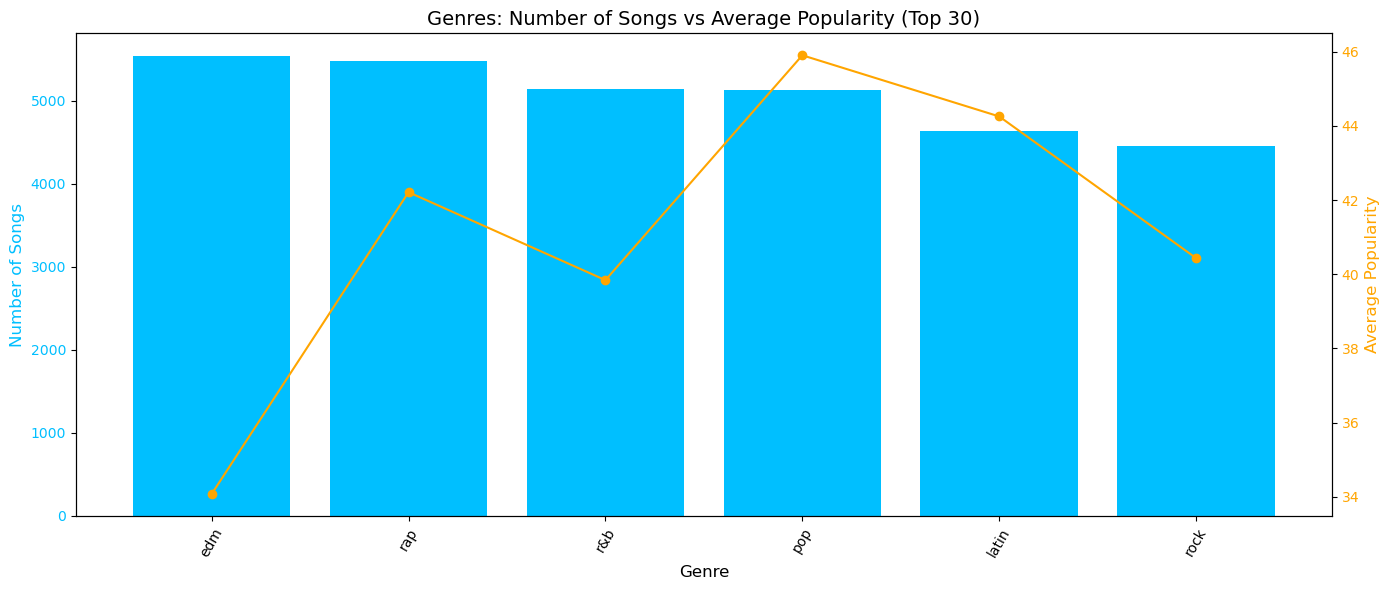

In [13]:
# Her genre'ın şarkı sayısını ve ortalama popülerliğini hesaplamak için gerekli işlemler yapıldı.
genre_cols = [col for col in data.columns if col.startswith('genre_')]
genre_stats = []
for genre_col in genre_cols:
    genre_name = genre_col.replace('genre_', '')
    song_count = data[genre_col].sum()
    avg_popularity = data.loc[data[genre_col] == 1, 'popularity'].mean()
    genre_stats.append({'Genre': genre_name, 'Song Count': song_count, 'Average Popularity': avg_popularity})

genre_stats_df = pd.DataFrame(genre_stats).sort_values(by='Song Count', ascending=False)
print("Genre number:", len(genre_stats_df))

# --- 3️⃣ En çok şarkıya sahip 30 genre seç ---
top_genres = genre_stats_df.head(30)

# --- 4️⃣ Grafik oluştur ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Şarkı sayısı (bar)
ax1.bar(top_genres['Genre'], top_genres['Song Count'], color='deepskyblue', label='Song Count')
ax1.set_xlabel('Genre', fontsize=12)
ax1.set_ylabel('Number of Songs', color='deepskyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='deepskyblue')
ax1.tick_params(axis='x', rotation=60)

# Ortalama popülerlik (çizgi)
ax2 = ax1.twinx()
ax2.plot(top_genres['Genre'], top_genres['Average Popularity'], color='orange', marker='o', label='Avg Popularity')
ax2.set_ylabel('Average Popularity', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

# Başlık ve legend
plt.title('Genres: Number of Songs vs Average Popularity (Top 30)', fontsize=14)
fig.tight_layout()
plt.show()

Genre number: 24


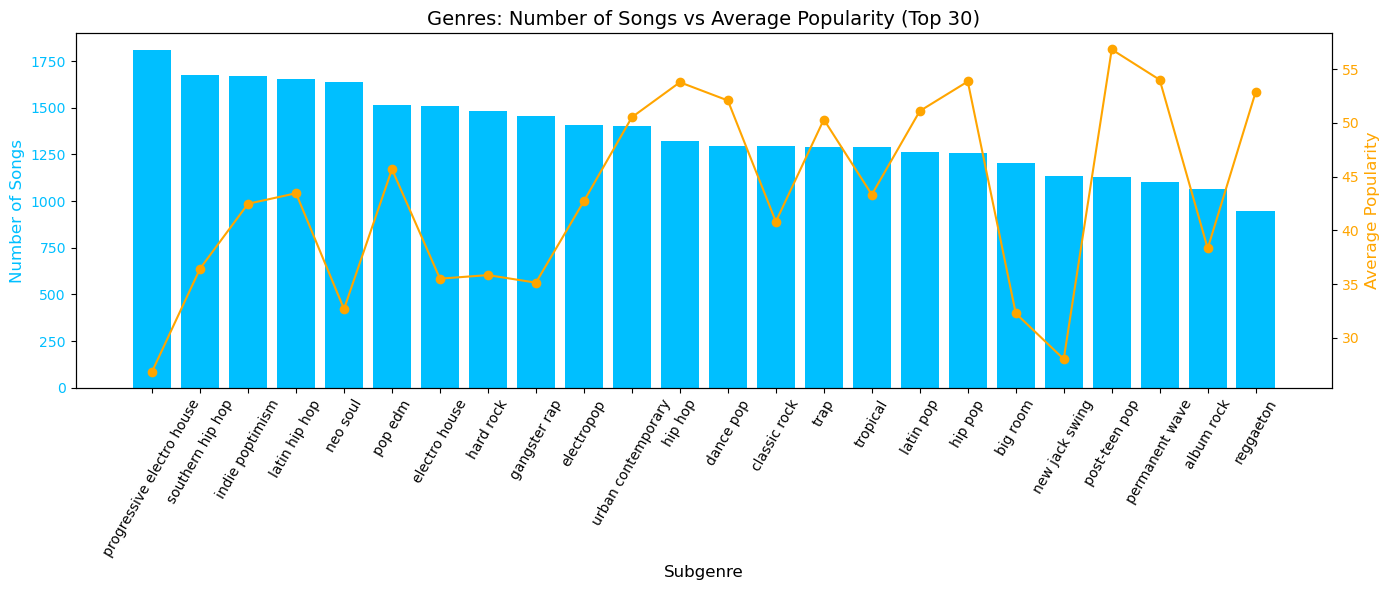

In [14]:
# Her subgenre’ın şarkı sayısını ve ortalama popülerliğini hesaplamak için gerekli işlemler yapıldı.
subgenre_cols = [col for col in data.columns if col.startswith('subgenre_')]

subgenre_stats = []
for subgenre_col in subgenre_cols:
    subgenre_name = subgenre_col.replace('subgenre_', '')
    song_count = data[subgenre_col].sum()
    avg_popularity = data.loc[data[subgenre_col] == 1, 'popularity'].mean()
    subgenre_stats.append({'Subgenre': subgenre_name, 'Song Count': song_count, 'Average Popularity': avg_popularity})


subgenre_stats_df = pd.DataFrame(subgenre_stats).sort_values(by='Song Count', ascending=False)
print("Genre number:", len(subgenre_stats_df))

# --- 3️⃣ En çok şarkıya sahip 30 subgenre seç ---
top_subgenres = subgenre_stats_df.head(30)

# --- 4️⃣ Grafik oluştur ---
fig, ax1 = plt.subplots(figsize=(14, 6))

# Şarkı sayısı (bar)
ax1.bar(top_subgenres['Subgenre'], top_subgenres['Song Count'], color='deepskyblue', label='Song Count')
ax1.set_xlabel('Subgenre', fontsize=12)
ax1.set_ylabel('Number of Songs', color='deepskyblue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='deepskyblue')
ax1.tick_params(axis='x', rotation=60)

# Ortalama popülerlik (çizgi)
ax2 = ax1.twinx()
ax2.plot(top_subgenres['Subgenre'], top_subgenres['Average Popularity'], color='orange', marker='o', label='Avg Popularity')
ax2.set_ylabel('Average Popularity', color='orange', fontsize=12)
ax2.tick_params(axis='y', labelcolor='orange')

# Başlık ve legend
plt.title('Genres: Number of Songs vs Average Popularity (Top 30)', fontsize=14)
fig.tight_layout()
plt.show()

In [15]:
# Tüm numerik sütunların değer aralıklarını kontrol et
print("TÜM SÜTUNLARIN DEĞER ARALIKLARI")
# Numerik sütunları al
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

# Her sütun için min, max, range bilgisini göster
range_info = pd.DataFrame({
    'Column': numeric_cols,
    'Min': [data[col].min() for col in numeric_cols],
    'Max': [data[col].max() for col in numeric_cols],
    'Range': [data[col].max() - data[col].min() for col in numeric_cols],
    'Mean': [data[col].mean() for col in numeric_cols],
    'Std': [data[col].std() for col in numeric_cols]
})

# Range'e göre sırala (büyükten küçüğe)
range_info = range_info.sort_values('Range', ascending=False)
print("RANGE'E GÖRE SIRALANMIŞ SÜTUNLAR:")
print(range_info.to_string(index=False))

# Normalize edilmesi gereken sütunları belirle (0-1 aralığında olmayanlar)
needs_normalization = range_info[(range_info['Min'] < 0) | (range_info['Max'] > 1)]
print("NORMALİZE EDİLMESİ GEREKEN SÜTUNLAR (0-1 dışında):")
if len(needs_normalization) > 0:
    print(needs_normalization[['Column', 'Min', 'Max', 'Range']].to_string(index=False))
else:
    print("Tüm sütunlar 0-1 aralığında! ✓")

# One-hot encoded sütunları kontrol et
one_hot_cols = [col for col in data.columns if col.startswith(('key_', 'genre_', 'subgenre_'))]
print(f"ONE-HOT ENCODED SÜTUNLAR: {len(one_hot_cols)} adet")


TÜM SÜTUNLARIN DEĞER ARALIKLARI
RANGE'E GÖRE SIRALANMIŞ SÜTUNLAR:
                            Column         Min        Max         Range          Mean          Std
                       duration_ms 4000.000000 517810.000 513810.000000 226575.967026 61078.450819
                             tempo    0.000000    239.440    239.440000    120.956180    26.954560
                 artist_song_count    1.000000    130.000    129.000000     11.385104    16.923553
                        popularity    0.000000    100.000    100.000000     39.329771    23.702376
             artist_avg_popularity    0.000000     97.000     97.000000     39.329771    17.504857
                         album_age    5.000000     68.000     63.000000     12.487657    10.070509
                          loudness  -46.448000      1.275     47.723000     -6.817696     3.036243
                               key    0.000000     11.000     11.000000      5.368000     3.613904
                    playlist_count    1.000

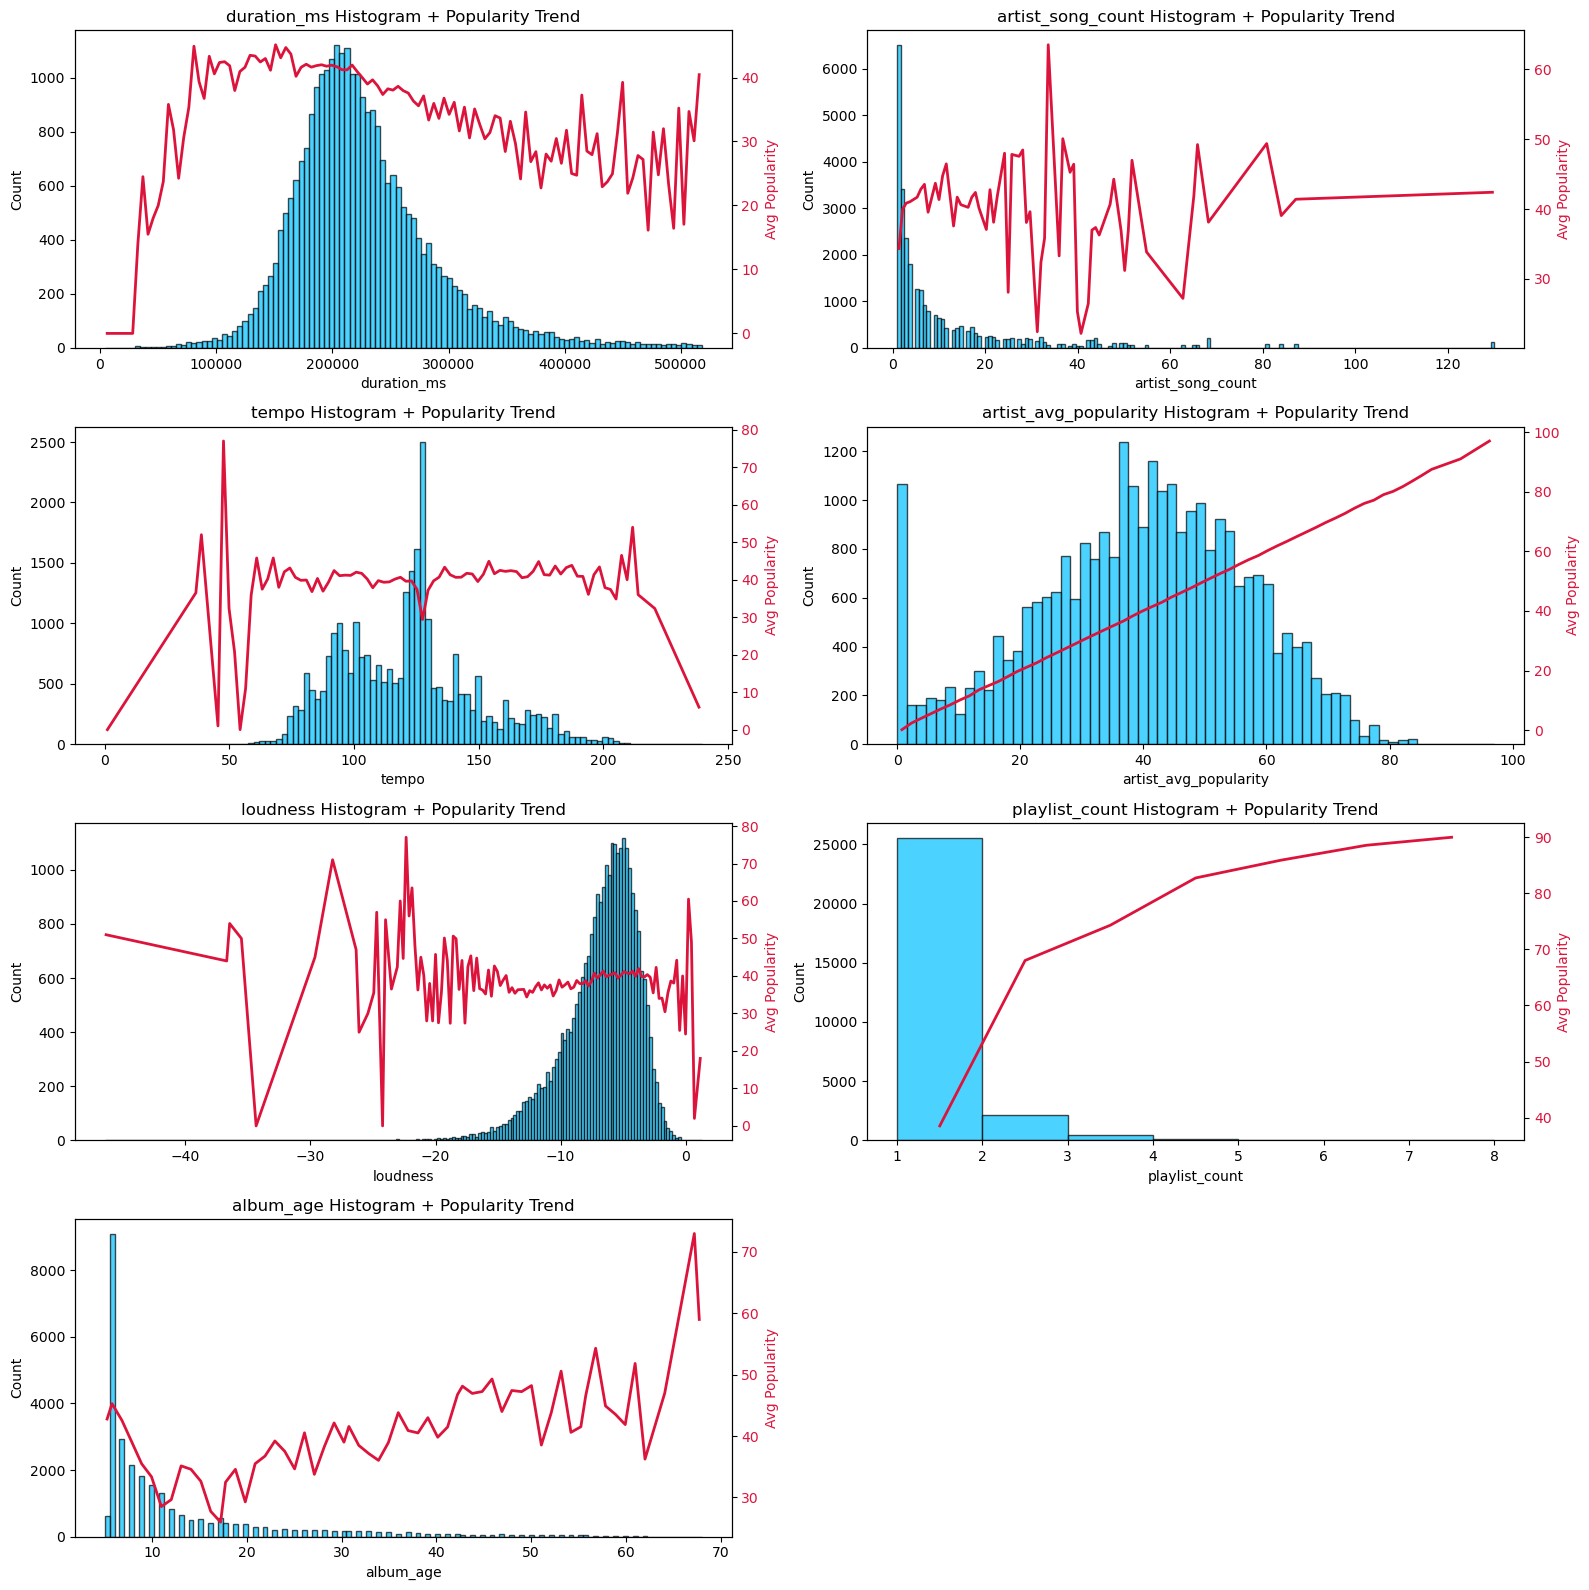

In [16]:
# Yeni dağılım grafikleri gösterildi.
cols_to_scale = ['duration_ms', 'artist_song_count', 'tempo', 'artist_avg_popularity', 'loudness', 'playlist_count', 'album_age']
n_cols = 2
n_rows = math.ceil(len(cols_to_scale) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
ax = ax.flatten()
cols_to_scale = cols_to_scale

for i, col in enumerate(cols_to_scale):
    # Histogram (önce otomatik bin aralıklarını al)
    counts, bins, patches = ax[i].hist(data[col], bins='auto', color='deepskyblue', edgecolor='black', alpha=0.7)
    
    # Popularity ortalamaları (bin aralıklarına göre)
    bin_labels = pd.cut(data[col], bins=bins, include_lowest=True)
    grouped = data.groupby(bin_labels)['popularity'].mean().dropna()
    centers = [interval.mid for interval in grouped.index]
    bin_means = grouped.values

    # Popularity çizgisi
    ax2 = ax[i].twinx()
    ax2.plot(centers, bin_means, color='crimson', linewidth=2)
    ax2.set_ylabel('Avg Popularity', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')

    ax[i].set_title(f'{col} Histogram + Popularity Trend')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

# Boş kalan hücreleri gizle
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [17]:
data["album_age_log"] = np.log1p(data["album_age"])

In [18]:
def playlist_binner(x):
    if x <= 1:
        return 0.0
    elif x == 2:
        return 0.5
    else:
        return 1.0

data["playlist_count_final"] = data["playlist_count"].apply(playlist_binner)

In [19]:
cols_to_scale = ['duration_ms', 'tempo', 'artist_avg_popularity', 'loudness', 'album_age_log']

In [20]:
# Normalizasyon işlemleri yapıldı:
# Tempo, loudness, duration_ms değer aralıkları geniş olduğu için min-max scaling uygulandı ve diğer feature'lar ile benzer ölçeğe getirildi.
from sklearn.preprocessing import MinMaxScaler, RobustScaler

minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()

# Fit ve transform işlemi
data[cols_to_scale] = minmax_scaler.fit_transform(data[cols_to_scale])

In [21]:
# import pandas as pd

# # Artist song count için binning - duplicates='drop' kullanarak
# data["artist_song_count_bin"] = pd.qcut(
#     data["artist_song_count"], 
#     q=5,  # 5 eşit parçaya böl
#     duplicates='drop'
# )

# # Kategorileri say ve dinamik mapping oluştur
# unique_bins = sorted(data["artist_song_count_bin"].unique())
# n_bins = len(unique_bins)

# # Dinamik numeric mapping oluştur (0'dan 1'e eşit aralıklı)
# if n_bins > 1:
#     bin_to_numeric = {bin_val: i / (n_bins - 1) for i, bin_val in enumerate(unique_bins)}
# else:
#     bin_to_numeric = {unique_bins[0]: 0.5}

# data["artist_song_count_final"] = data["artist_song_count_bin"].map(bin_to_numeric)

# print(f"Oluşturulan bin sayısı: {n_bins}")
# print(f"Bin aralıkları: {unique_bins}")
# print(f"Mapping: {bin_to_numeric}")
data["artist_song_count_bin"] = pd.qcut(
    data["artist_song_count"].rank(method="first"),
    q=[0, 0.25, 0.5, 0.75, 1.0],
    labels=[0.0, 0.33, 0.66, 1.0]
)
data["artist_song_count_final"] = data["artist_song_count_bin"].astype(float)

In [22]:
# Hangi aralıklara hangi değerler dahil kontrol edelim
print("ARTIST SONG COUNT BIN ARALIKLARI")
# Her kategorinin min, max ve count değerlerini göster
bin_stats = data.groupby('artist_song_count_final')['artist_song_count'].agg(['min', 'max', 'count'])
print(bin_stats)

ARTIST SONG COUNT BIN ARALIKLARI
                          min    max  count
artist_song_count_final                    
0.00                      1.0    2.0   7089
0.33                      2.0    5.0   7089
0.66                      5.0   14.0   7089
1.00                     14.0  130.0   7089


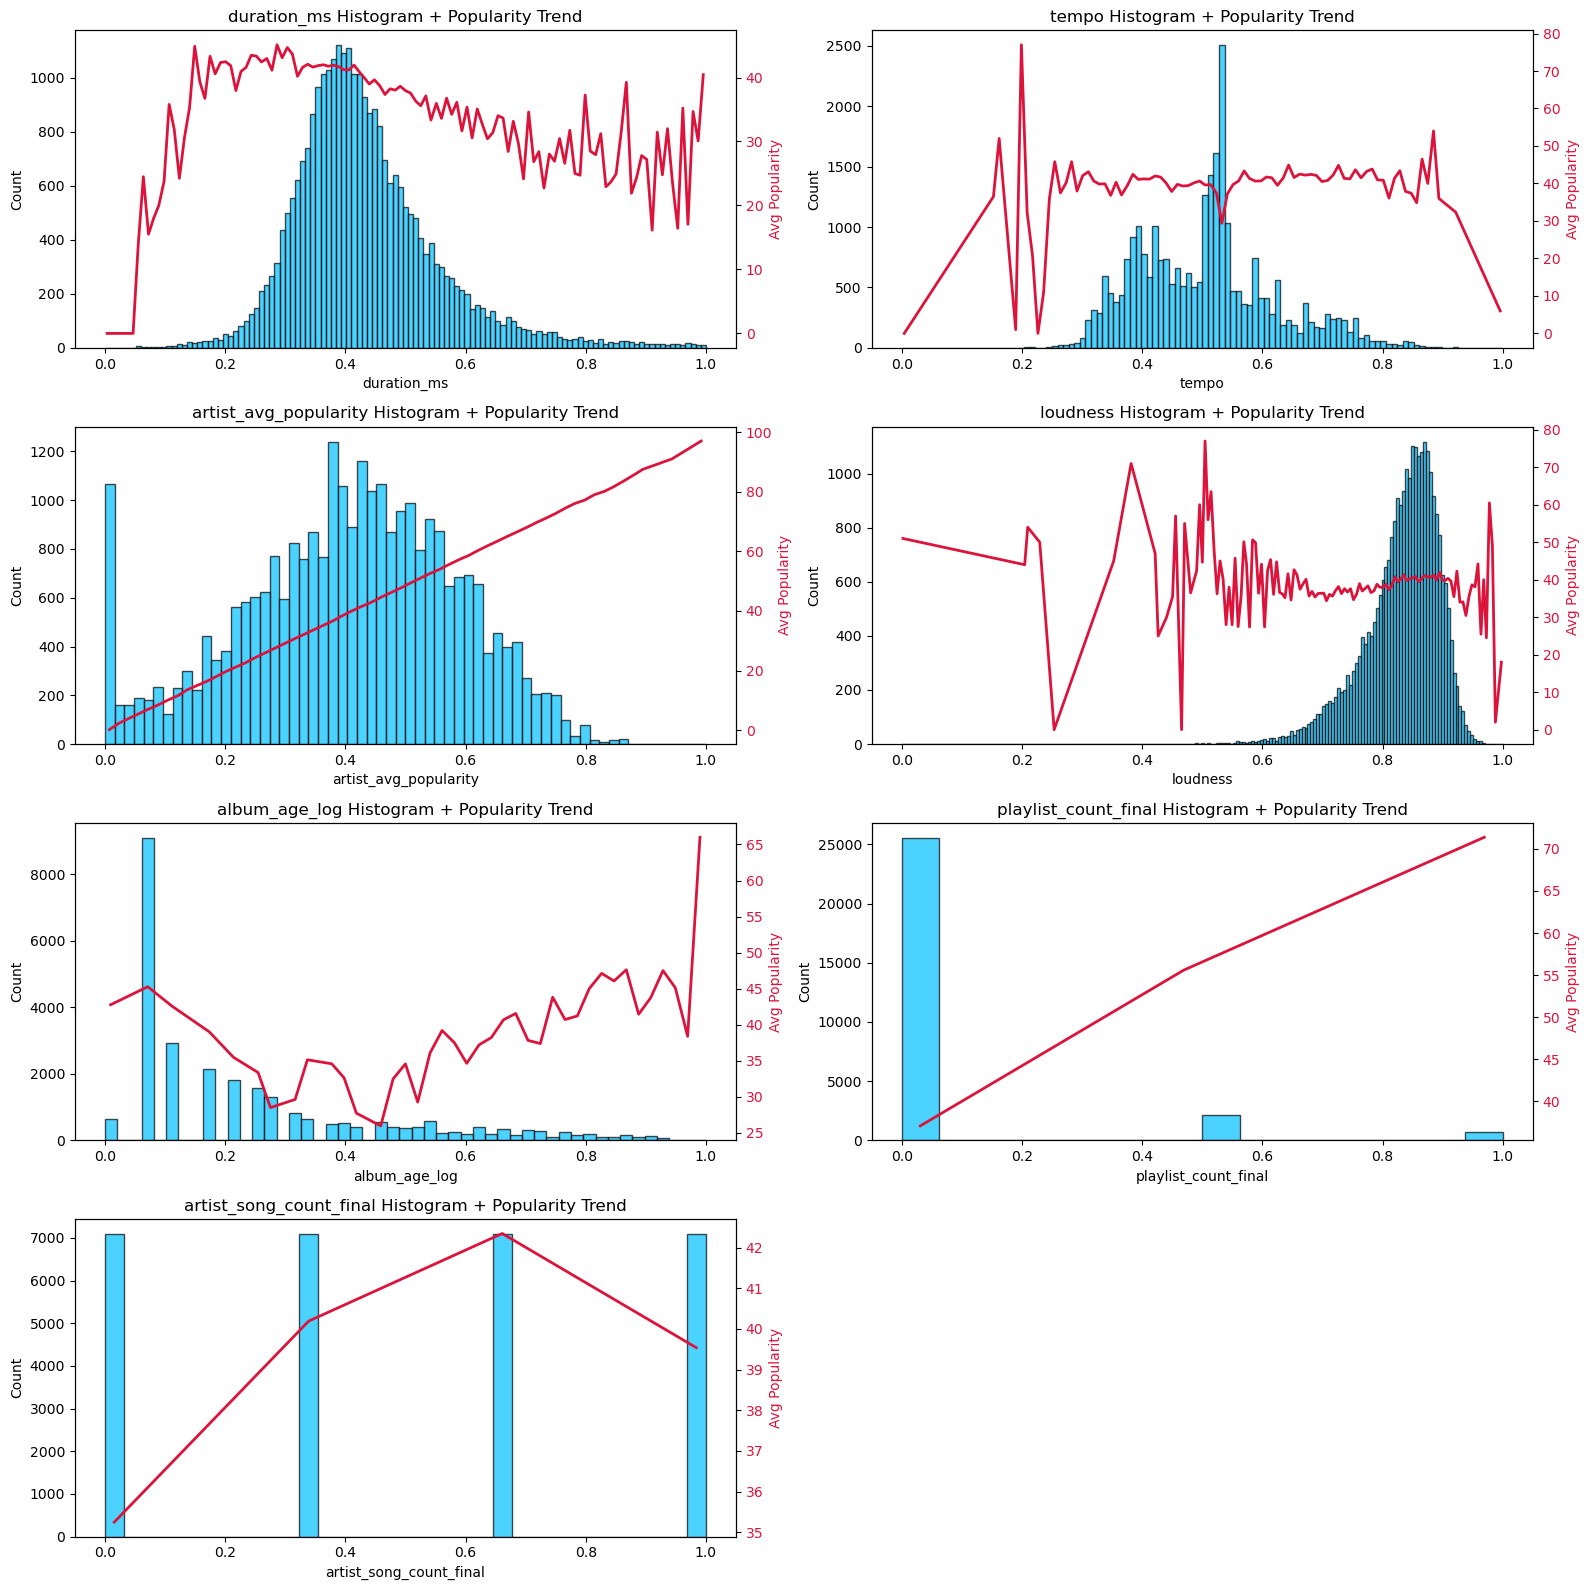

In [23]:
# Yeni dağılım grafikleri gösterildi.
cols_to_plot = cols_to_scale + ['playlist_count_final'] + ['artist_song_count_final']
n_cols = 2
n_rows = math.ceil(len(cols_to_plot) / n_cols)

fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
ax = ax.flatten()

for i, col in enumerate(cols_to_plot):
    # Histogram (önce otomatik bin aralıklarını al)
    counts, bins, patches = ax[i].hist(data[col], bins='auto', color='deepskyblue', edgecolor='black', alpha=0.7)
    
    # Popularity ortalamaları (bin aralıklarına göre)
    bin_labels = pd.cut(data[col], bins=bins, include_lowest=True)
    grouped = data.groupby(bin_labels)['popularity'].mean().dropna()
    centers = [interval.mid for interval in grouped.index]
    bin_means = grouped.values

    # Popularity çizgisi
    ax2 = ax[i].twinx()
    ax2.plot(centers, bin_means, color='crimson', linewidth=2)
    ax2.set_ylabel('Avg Popularity', color='crimson')
    ax2.tick_params(axis='y', labelcolor='crimson')

    ax[i].set_title(f'{col} Histogram + Popularity Trend')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Count')

# Boş kalan hücreleri gizle
for j in range(i + 1, len(ax)):
    fig.delaxes(ax[j])

plt.tight_layout()
plt.show()

In [24]:
print("Önceki column sayısı" + str(len(data.columns)))
print(data.columns)

Önceki column sayısı58
Index(['track_id', 'name', 'artist', 'album_id', 'album_name', 'popularity',
       'album_release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count', 'genre_edm',
       'genre_latin', 'genre_pop', 'genre_r&b', 'genre_rap', 'genre_rock',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgen

In [25]:
# Modele dahil edilmeyecek sütunlar kaldırıldı.
columns_to_drop = [ 'album_id', 
                   'album_name', 
                   'name', 
                   'album_release_date', 
                   'track_id',
                   'artist',
                   'artist_song_count_bin',
                   'artist_song_count',
                   'key'
]
genres = [c for c in data.columns if c.startswith('genre_')]
data.drop(genres, axis=1, inplace=True)
data = data.drop(columns=columns_to_drop)
print("Columns after drop " +  str(data.columns))
print(len(data.columns))

Columns after drop Index(['popularity', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'playlist_count',
       'subgenre_album rock', 'subgenre_big room', 'subgenre_classic rock',
       'subgenre_dance pop', 'subgenre_electro house', 'subgenre_electropop',
       'subgenre_gangster rap', 'subgenre_hard rock', 'subgenre_hip hop',
       'subgenre_hip pop', 'subgenre_indie poptimism',
       'subgenre_latin hip hop', 'subgenre_latin pop', 'subgenre_neo soul',
       'subgenre_new jack swing', 'subgenre_permanent wave',
       'subgenre_pop edm', 'subgenre_post-teen pop',
       'subgenre_progressive electro house', 'subgenre_reggaeton',
       'subgenre_southern hip hop', 'subgenre_trap', 'subgenre_tropical',
       'subgenre_urban contemporary', 'artist_avg_popularity',
       'artist_high_pop_ratio', 'album_age', 'album_age_log',
       'playlist_count_final', 'artist_song_c

In [26]:
# İşlenmiş veriyi kaydet
data.to_csv('final_data.csv', index=False)
print(f"✅ Veri kaydedildi: final_data.csv")
print(f"📊 Shape: {data.shape}")
print(f"📋 Sütun sayısı: {len(data.columns)}")

✅ Veri kaydedildi: final_data.csv
📊 Shape: (28356, 43)
📋 Sütun sayısı: 43
